#### Imports

In [1]:
from typing import List
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService
import numpy as np

# Deutsch Josza Algorithm
The Deutsch Jpsza Algorithm detemines if a given function $f(x)$ is constant or balanced with a quantum approach
Steps:
1. Start with state $\ket{01} = \ket{0} \otimes \ket{1}$
1. Apply H-gate transformation H to both bits
1. Apply function $f$
1. Apply H-tranform to both bits
1. Measure the firest bit of the resulting 2-bit state:
    * If the first bit is 0, we conclude that function $f$ is constant
    * If the first bit is 1, we conclude that function $f$ is not constant


#### Oracle (Black Box)
The Oracle is the black box in this algorithm that takes an input $x$ and flips the output qubit if $f(x) = 1$.

There are 2 types of oracles:
1. Constant Oracle: For a constant function (always 0 or always 1), the oracle does nothing if always 0 or applies x gate to output qubit if always 1.
1. Balanced Oracle: for a balanced function we can use a CNOT gate controlled by one of the input qubits

In [2]:
def create_oracle(n: int):
    a = 0
    oracle_type = np.random.randint(
        2
    )  # Sets the oracle type to be either constant (0) or balanced (1),
    oracle_value = np.random.randint(
        2
    )  # and in the case it's constant, to the value it should return 0 or 1

    if oracle_type == 0:
        print(f"The oracle returns a constant value: {oracle_value}")
    else:
        print("The oracle returns a balanced function")
        a = np.random.randint(1, 2**n)  # A hidden parameter for the balanced oracle

    return (oracle_type, oracle_value, a)

In [3]:
def dja_estimator(num_bits: int = 0, oracle_labels: List[str] = []):
    qr = QuantumRegister(num_bits + 1)  # Additional Qubit for saving the result
    circuit = QuantumCircuit(qr)  # Creates the circuit

    # Create superposition for the cicuit
    for i in range(num_bits):
        circuit.h(qr[i])

    # Create the ancilla (flip last bit and apply x-gate)
    circuit.x(qr[num_bits])
    circuit.h(qr[num_bits])

    circuit.barrier()  # Denote the oracle
    oracle_values = create_oracle(num_bits)
    oracle_type = "constant" if oracle_values[0] == 0 else "balanced"
    oracle_labels.append(oracle_type)
    if oracle_type == "constant":
        if oracle_values[1] == 1:
            circuit.x(qr[num_bits])
        else:
            circuit.id(qr[num_bits])
    else:
        for i in range(num_bits):
            if oracle_values[2] & (1 << i):
                circuit.cx(qr[i], qr[num_bits])
    circuit.barrier()  # End the oracle section

    for i in range(num_bits):
        circuit.h(qr[i])

    return circuit

The oracle returns a constant value: 0


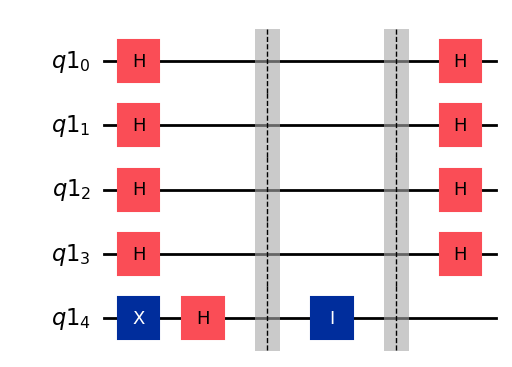

In [4]:
n = 4
quantum_circuit = dja_estimator(n)
observable = SparsePauliOp("Z" * n + "I")

quantum_circuit.draw("mpl")

### Testing on Quantum Computer

In [13]:
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="",
)
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name

'ibm_kyiv'

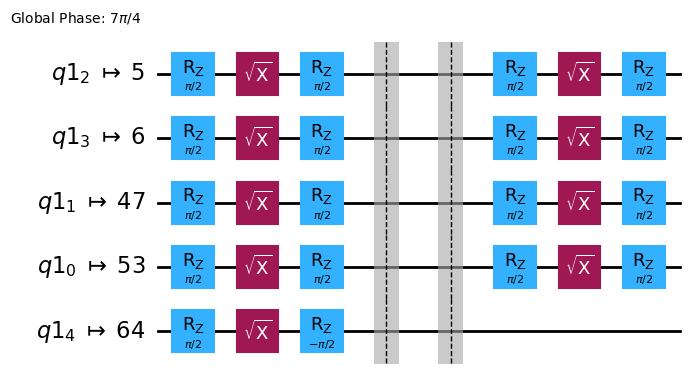

In [6]:
# Generate an optimized quantum circuit for the selected backend
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
isa_circuit = pm.run(quantum_circuit)
# Visualize optimized circuit
isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")

In [7]:
isa_observable = observable.apply_layout(layout=isa_circuit.layout)

In [8]:
estimator = Estimator(mode=backend)
pub = (isa_circuit, [[isa_observable]])
job_result = estimator.run(pubs=[pub]).result()

In [9]:
job_result[0].data.evs[0]

array([0.01413798])

In [14]:
num_trials = 10
n = 4
estimator = Estimator(mode=backend)
expectation_values = []
oracle_labels = []

# %% Executing Trials
for _ in range(num_trials):
    qc = dja_estimator(n, oracle_labels)
    q_observalbe = SparsePauliOp("Z" * n + "I")

    # Translate to isa_circuits
    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)
    isa_circuit = pm.run(qc)
    isa_observable = observable.apply_layout(layout=isa_circuit.layout)
    pub = (
        isa_circuit, [[isa_observable]]
    )
    job_result = estimator.run(pubs=[pub]).result()

    expectation_values.append(job_result[0].data.evs[0])


The oracle returns a constant value: 1
The oracle returns a constant value: 0
The oracle returns a constant value: 1
The oracle returns a balanced function
The oracle returns a constant value: 0
The oracle returns a balanced function
The oracle returns a constant value: 0
The oracle returns a constant value: 0
The oracle returns a balanced function
The oracle returns a constant value: 0


In [15]:
print(f"DJA Results:\n{expectation_values}")
print("------------------------------------------------------------------")
print(f"Oracle Labels:\n{oracle_labels}")

DJA Results:
[array([-0.00955795]), array([-0.0025181]), array([-0.0065261]), array([-0.00510139]), array([-0.00754527]), array([-0.01263025]), array([0.01806889]), array([-0.01003827]), array([0.01214037]), array([0.02503286])]
------------------------------------------------------------------
Oracle Labels:
['constant', 'constant', 'constant', 'balanced', 'constant', 'balanced', 'constant', 'constant', 'balanced', 'constant']


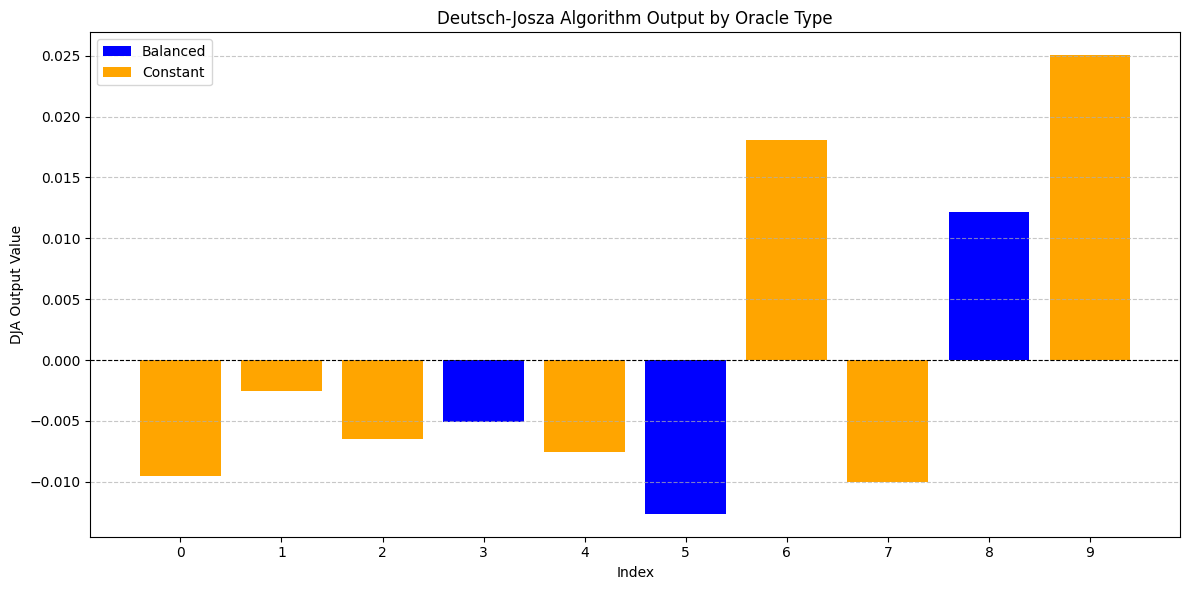

In [16]:
dja_values = [val[0] if isinstance(val, np.ndarray) else val for val in expectation_values]
# Group DJA values by their Oracle Label
balanced_values = [dja_values[i] for i in range(len(oracle_labels)) if oracle_labels[i] == 'balanced']
constant_values = [dja_values[i] for i in range(len(oracle_labels)) if oracle_labels[i] == 'constant']
balanced_indices = [i for i in range(len(oracle_labels)) if oracle_labels[i] == 'balanced']
constant_indices = [i for i in range(len(oracle_labels)) if oracle_labels[i] == 'constant']

# Create the plot with two separate bars
plt.figure(figsize=(12, 6))
plt.bar(balanced_indices, balanced_values, color='blue', label='Balanced')
plt.bar(constant_indices, constant_values, color='orange', label='Constant')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel('Index')
plt.ylabel('DJA Output Value')
plt.title('Deutsch-Josza Algorithm Output by Oracle Type')
plt.legend()
plt.xticks(range(len(dja_values)))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
